In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten
from tensorflow.keras.models import Model,load_model


# from keras.applications.resnet_v2 import ResNet152V2  
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = 'drive/MyDrive/Colab Notebooks/Cotton Disease/train'
valid_path = 'drive/MyDrive/Colab Notebooks/Cotton Disease/val'
test_path='drive/MyDrive/Colab Notebooks/Cotton Disease/test'

In [ ]:
# resnet152V2 =ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#removing top layer to add our own image size
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [ ]:
for layer in inception.layers:
    layer.trainable = False#using the same weights as downloaded

In [ ]:
output_classes=glob("drive/MyDrive/Colab Notebooks/Cotton Disease/train/*")

In [ ]:
output_classes

['drive/MyDrive/Colab Notebooks/Cotton Disease/train/diseased cotton leaf',
 'drive/MyDrive/Colab Notebooks/Cotton Disease/train/fresh cotton leaf',
 'drive/MyDrive/Colab Notebooks/Cotton Disease/train/fresh cotton plant',
 'drive/MyDrive/Colab Notebooks/Cotton Disease/train/diseased cotton plant']

In [ ]:
len(output_classes)

4

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(output_classes), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=30, fill_mode='nearest',
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


**Rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255.**<br>
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/rotation.png)<br>
**Rotation**

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/zoom.png)<br>
**Zoom:Any value smaller than 1 will zoom in on the image. Whereas any value greater than 1 will zoom out on the image.**

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/01/Plot-of-Augmented-Images-with-a-Horizontal-Flip.png" width="600" height="300"><br>
**Horizontal flip:An image flip means reversing the rows or columns of pixels in the case of a vertical or horizontal flip respectively.**

<img src="https://i.stack.imgur.com/HMkAE.png"><br>
**'Shear' means that the image will be distorted along an axis, mostly to create or rectify the perception angles. It's usually used to augment images so that computers can see how humans see things from different angles.**

In [ ]:
training_set = train_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [ ]:
valid_set = test_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('drive/MyDrive/Colab Notebooks/Cotton Disease/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 253 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
  raise SystemError("GPU not found")
print("device found",device_name)

device found /device:GPU:0


In [ ]:
from keras.callbacks import ModelCheckpoint

model_path = '/content/drive/My Drive/inceptionV3.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
with tf.device("/gpu:0"):

  r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=callbacks_list
  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 13.4725 - accuracy: 0.6243
Epoch 1: val_accuracy improved from -inf to 0.79245, saving model to /content/drive/My Drive/inceptionV3.h5
61/61 [==============================] - 45s 671ms/step - loss: 13.4725 - accuracy: 0.6243 - val_loss: 2.6536 - val_accuracy: 0.7925
Epoch 2/10
61/61 [==============================] - ETA: 0s - loss: 2.9489 - accuracy: 0.8355
Epoch 2: val_accuracy improved from 0.79245 to 0.90566, saving model to /content/drive/My Drive/inceptionV3.h5
61/61 [==============================] - 39s 635ms/step - loss: 2.9489 - accuracy: 0.8355 - val_loss: 0.7031 - val_accuracy: 0.9057
Epoch 3/10
61/61 [==============================] - ETA: 0s - loss: 1.8358 - accuracy: 0.8616
Epoch 3: val_accuracy did not improve from 0.90566
61/61 [==============================] - 39s 632ms/step - loss: 1.8358 - accuracy: 0.8616 - val_loss: 1.0541 - val_accuracy: 0.8585
Epoch 4/10
61/61 [==============================] 

In [ ]:
saved_model=load_model("/content/drive/MyDrive/inceptionV3.h5")

In [ ]:
saved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
with tf.device("/gpu:0"):
  _, acc = saved_model.evaluate_generator(training_set, steps=len(training_set), verbose=0)
  print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


> 93.132


In [ ]:
with tf.device("/gpu:0"):
  _, acc = saved_model.evaluate_generator(valid_set, steps=len(valid_set), verbose=0)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


> 93.281


In [ ]:
with tf.device("/gpu:0"):
  _, acc = saved_model.evaluate_generator(test_set, steps=len(test_set), verbose=0)
  print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


> 97.170


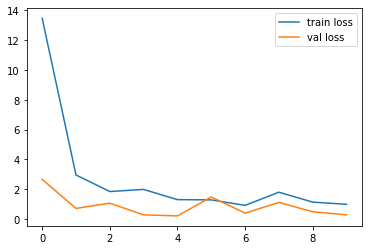

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('LossVal_loss')



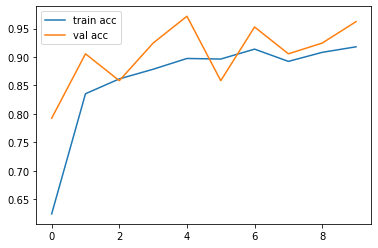

In [ ]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = saved_model.predict(test_set)

In [ ]:
y_pred

array([[9.91630137e-01, 5.35863976e-14, 6.18876839e-10, 8.36979225e-03],
       [1.00000000e+00, 7.24262975e-15, 4.36407256e-19, 1.12030496e-09],
       [4.72059769e-09, 4.51683719e-03, 6.64061591e-15, 9.95483160e-01],
       [1.47663954e-07, 9.99999046e-01, 8.03653506e-07, 1.61853847e-13],
       [1.70894884e-20, 1.00000000e+00, 7.02522998e-24, 2.54252565e-13],
       [1.34506053e-07, 9.99874592e-01, 1.25297825e-04, 2.91658435e-13],
       [2.46320244e-08, 4.62499259e-38, 1.00000000e+00, 9.49151047e-28],
       [5.07071773e-10, 5.90638538e-10, 9.91141804e-12, 1.00000000e+00],
       [1.09166044e-30, 6.55931279e-23, 6.25468213e-26, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 7.78533625e-38, 4.33440888e-26],
       [5.93720308e-08, 3.96781106e-04, 3.87338463e-13, 9.99603212e-01],
       [3.85334383e-31, 2.23054427e-16, 7.85042606e-34, 1.00000000e+00],
       [1.48737653e-24, 1.80367130e-16, 1.94778509e-26, 1.00000000e+00],
       [3.31433660e-30, 1.00000000e+00, 0.00000000e

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 3, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 1, 2, 3, 2, 3, 0, 3, 3, 1,
       2, 1, 2, 2, 1, 1, 3, 1, 1, 0, 1, 0, 1, 0, 1, 3, 2, 0, 2, 2, 1, 0,
       1, 0, 3, 1, 1, 0, 3, 3, 0, 3, 0, 2, 3, 2, 2, 0, 1, 2, 2, 1, 1, 0,
       2, 2, 0, 0, 2, 1, 0, 2, 3, 1, 0, 1, 2, 3, 2, 2, 0, 2, 3, 2, 2, 3,
       0, 3, 1, 3, 0, 0, 3, 1, 2, 1, 0, 0, 2, 3, 0, 2, 0, 1])

In [ ]:
import cv2
import tensorflow as tf

In [ ]:
test_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [ ]:
from keras.preprocessing.image import img_to_array

def pred_cot_dieas(cott_plant):
  test_image = load_img(cott_plant,target_size=(224,224,3)) # load image 

  plt.imshow(test_image)
  test_image = img_to_array(test_image)/255 # convert image to np array and normalize
  test_image = np.expand_dims(test_image, axis = 0) # change dimention 3D to 4D
   
  result = saved_model.predict(test_image).round(3) # predict diseased plant or not

   
  pred = np.argmax(result) # get the index of max value

  if pred == 0:
    return "Diseased Cotton Leaf" # if index 0 burned leaf
  elif pred == 1:
      return 'Diseased Cotton Plant' # # if index 1
  elif pred == 2:
      return 'Healthy Cotton Leaf'  # if index 2  fresh leaf
  else:
    return "Healthy Cotton Plant" # if index 3

'Diseased Cotton Plant'

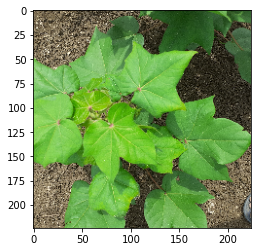

In [ ]:
pred_cot_dieas("/content/drive/MyDrive/Colab Notebooks/Cotton Disease/test/diseased cotton plant/dd (328).jpg")